In [ ]:
!git clone https://github.com/AlexeyAB/darknet


Cloning into 'darknet'...
remote: Enumerating objects: 15530, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15530 (delta 6), reused 10 (delta 4), pack-reused 15514
Receiving objects: 100% (15530/15530), 14.21 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (10418/10418), done.


In [3]:
import cv2
import os
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

shape = 224
classes = []

In [4]:
class Dataset:
    def __init__(self, shape):
        self.path = "/content/drive/MyDrive/data1"
        self.data_files = os.listdir(self.path)
        self.data_csv = 0
        self.x_data = []
        self.y_bbox_data = []
        self.y_label_data = []
        self.x_data_files = []
        self.y_data_files = []
        self.labels = []
        self.shape = shape

    def __preprocessing_image(self, path):
        image = cv2.imread(path)
        image = cv2.resize(image, (shape, shape))
        image = np.reshape(image, (shape, shape, 3))
        image = np.array(image, dtype = "float32")
        image /= 255.0

        return image

    def __seperating_images_labels(self):
        for data_file in self.data_files:
            if data_file.split(".")[-1] == "txt":
                data = open(f"{self.path}/{data_file}", "r").readline().split()
                df = pd.DataFrame()
                df["filename"] = [data_file]
                df["class"] =[float(data[0])]
                df["xmin"] = [float(data[1])]
                df["ymin"] = [float(data[2])]
                df["xmax"] = [float(data[3])]
                df["ymax"] = [float(data[4])]
                self.y_data_files.append(df)

        self.data_csv = pd.concat(self.y_data_files)
        for i in list(self.data_csv.columns[2:]):
            self.data_csv[i] = self.data_csv[i].astype(float)

    def __extract_images(self):
        self.images_paths = self.data_csv["filename"].values
        for image in self.images_paths:
            self.x_data.append(self.__preprocessing_image(self.path + "/" + image.split(".")[0] + ".jpeg"))

    def __extract_labels(self):
        global classes
        self.classes = self.data_csv["class"].unique().tolist()
        classes = self.classes
        self.y_label_data = self.data_csv["class"].values
        self.y_label_data = [self.classes.index(i) for i in self.y_label_data]
        self.y_label_data = keras.utils.to_categorical(self.y_label_data)
        self.y_label_data = np.array(self.y_label_data, dtype = "float32")

    def __extract_bboxes(self):
        for index, _ in enumerate(self.data_csv["xmin"].values):
            self.y_bbox_data.append(self.data_csv.iloc[[index]].values[0])
        self.y_bbox_data = np.array(self.y_bbox_data, dtype= "float32")

    def load_data(self):
        self.__seperating_images_labels()
        self.__extract_labels()
        self.__extract_images()
        self.data_csv = self.data_csv.drop('class', axis = 1)
        self.data_csv = self.data_csv.drop('filename', axis = 1)
        self.__extract_bboxes()

        return train_test_split(self.x_data, self.y_label_data, self.y_bbox_data, random_state = 42, shuffle = True)

dataset = Dataset(shape)
split = dataset.load_data()

In [6]:
(x_train, x_test) = split[:2]
(y_class_train, y_class_test) = split[2:4]
(y_bbox_train, y_bbox_test) = split[4:]
x_train = np.array(x_train, dtype = "float32")
x_test = np.array(x_test, dtype = "float32")
#y_bbox_train = np.reshape(y_bbox_train, (y_bbox_train.shape[0], 4))
#y_bbox_test =  np.reshape(y_bbox_test,  (y_bbox_test.shape[0], 4))
y_bbox_train = np.array(y_bbox_train, dtype = "float32")
y_bbox_test = np.array(y_bbox_test, dtype = "float32")
y_class_train = np.array(y_class_train, dtype = "float32")
y_class_test = np.array(y_class_test, dtype = "float32")

print(f"X_Train Shape : {x_train.shape}")
print(f"X_Test Shape : {x_test.shape}")
print(f"Y_class_Train Shape : {y_class_train.shape}")
print(f"Y_class_Test Shape : {y_class_test.shape}")
print(f"Y_bbox_Train Shape : {y_bbox_train.shape}")
print(f"Y_bbox_Test Shape : {y_bbox_test.shape}")

del dataset
del split
gc.collect()



X_Train Shape : (978, 224, 224, 3)
X_Test Shape : (327, 224, 224, 3)
Y_class_Train Shape : (978, 2)
Y_class_Test Shape : (327, 2)
Y_bbox_Train Shape : (978, 4)
Y_bbox_Test Shape : (327, 4)


0

In [7]:
class Model():
    def __init__(self, cnn):
        self.model_input1 = keras.layers.Input((shape, shape, 3))
        self.cnn = cnn(weights = "imagenet", include_top = False, input_tensor = self.model_input1)
        for layer in self.cnn.layers:
            layer.trainable = False
        self.__build_model()
        self.plot_loss_acc()

    def __build_model(self):

        flatten = keras.layers.Flatten()(self.cnn.output)
        x = keras.layers.Dense(1024, activation = "relu", kernel_initializer ="he_normal")(flatten)
        x = keras.layers.Dense(512, activation = "relu", kernel_initializer = "he_normal")(x)
        x = keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal")(x)
        x = keras.layers.Dense(128, activation = "relu", kernel_initializer = "he_normal")(x)
        output_1 = keras.layers.Dense(len(classes), activation = "softmax", name = "Class")(x)

        x = keras.layers.Dense(256, activation = "relu", kernel_initializer ="he_normal")(flatten)
        x = keras.layers.Dense(128, activation = "relu", kernel_initializer ="he_normal")(x)
        x = keras.layers.Dense(64, activation = "relu", kernel_initializer = "he_normal")(x)
        x = keras.layers.Dense(32, activation = "relu", kernel_initializer = "he_normal")(x)
        output_2 = keras.layers.Dense(4, activation = "sigmoid", name = "BBOX")(x)

        optimizer = keras.optimizers.Adam(1e-4)
        self.model = keras.models.Model(inputs = [self.model_input1], outputs = [output_1, output_2])
        losses = {"Class": "categorical_crossentropy","BBOX": "mse"}
        lossWeights = {"Class": 1.0, "BBOX": 1.0}
        self.model.compile(optimizer = optimizer, loss = losses, metrics = ["accuracy"])

        #display(keras.utils.plot_model(self.model))
        checkpoint = keras.callbacks.ModelCheckpoint("./model.h5")

        self.model.fit(x_train, y = {"Class":y_class_train, "BBOX":y_bbox_train},
                       epochs = 5, validation_data = (x_test, {"Class":y_class_test, "BBOX":y_bbox_test}),
                       shuffle = True, callbacks = [checkpoint])

    def plot_loss_acc(self):
        #Loss vs Epochs
        plt.plot(self.model.history.history['Class_loss'], label='train')
        plt.plot(self.model.history.history['val_Class_loss'], label='test')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epochs")
        plt.legend()
        plt.show()
        #Accuracy vs Epochs
        plt.plot(self.model.history.history['Class_accuracy'], label='train')
        plt.plot(self.model.history.history['val_Class_accuracy'], label='test')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"ACCURACY vs Epochs")
        plt.legend()
        plt.show()


171446536/171446536 [==============================] - 2s 0us/step
Epoch 1/5
31/31 [==============================] - 507s 16s/step - loss: 0.8321 - Class_loss: 0.7974 - BBOX_loss: 0.0347 - Class_accuracy: 0.6012 - BBOX_accuracy: 0.3998 - val_loss: 0.5450 - val_Class_loss: 0.5219 - val_BBOX_loss: 0.0231 - val_Class_accuracy: 0.8073 - val_BBOX_accuracy: 0.6330
Epoch 2/5
31/31 [==============================] - 554s 18s/step - loss: 0.5888 - Class_loss: 0.5625 - BBOX_loss: 0.0263 - Class_accuracy: 0.6800 - BBOX_accuracy: 0.5389 - val_loss: 0.8160 - val_Class_loss: 0.7933 - val_BBOX_loss: 0.0227 - val_Class_accuracy: 0.5076 - val_BBOX_accuracy: 0.5229
Epoch 3/5
31/31 [==============================] - 530s 17s/step - loss: 0.4873 - Class_loss: 0.4638 - BBOX_loss: 0.0235 - Class_accuracy: 0.7761 - BBOX_accuracy: 0.5481 - val_loss: 0.3945 - val_Class_loss: 0.3755 - val_BBOX_loss: 0.0190 - val_Class_accuracy: 0.8532 - val_BBOX_accuracy: 0.6361
Epoch 4/5
31/31 [==============================]

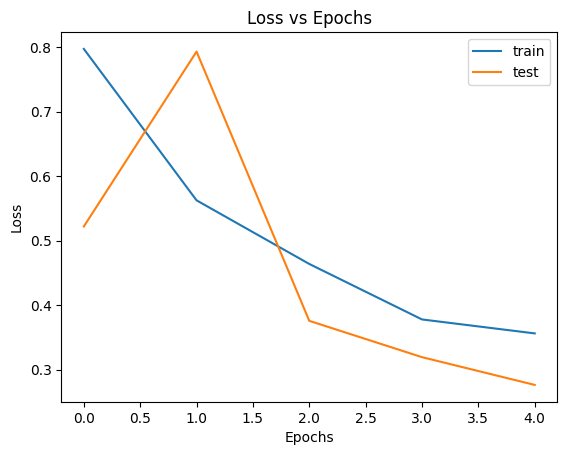

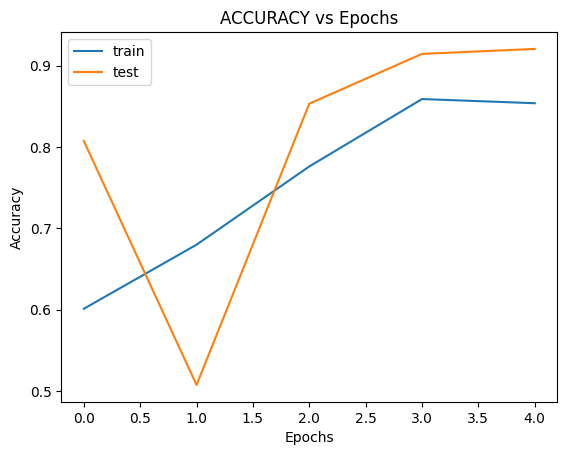

In [8]:
model = Model(keras.applications.resnet.ResNet101)


1/1 [==============================] - 2s 2s/step
[[0.97468424 0.02531578]]


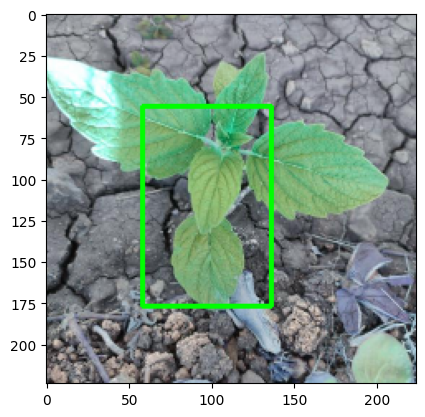

In [9]:
image = cv2.imread("/content/drive/MyDrive/data1/agri_0_1214.jpeg")
image = cv2.resize(image, (shape, shape))
image_1 = np.reshape(image, (1 ,shape, shape, 3))
pred = model.model.predict(image_1)
print(pred[0])
startX = int(pred[1][0][0] * 224)
startY = int(pred[1][0][1] * 224)
endX =   int(pred[1][0][2] * 224)
endY =   int(pred[1][0][3] * 224)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(image)

1/1 [==============================] - 1s 965ms/step
[[0.82901126 0.1709888 ]]


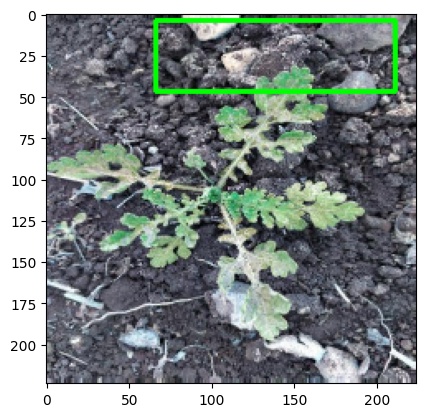

In [10]:
image = cv2.imread("/content/drive/MyDrive/data1/agri_0_4436.jpeg")
image = cv2.resize(image, (shape, shape))
image_1 = np.reshape(image, (1 ,shape, shape, 3))
pred = model.model.predict(image_1)
print(pred[0])
startX = int(pred[1][0][0] * 224)
startY = int(pred[1][0][1] * 224)
endX =   int(pred[1][0][2] * 224)
endY =   int(pred[1][0][3] * 224)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
plt.imshow(image)